# Importing Libraries and Loading Data:

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from keras.layers import Dense,Input,LSTM,Bidirectional,Activation,Conv1D,GRU, CuDNNLSTM, add, Conv2D, Reshape
from keras.callbacks import Callback
from keras.layers import Dropout,Embedding,GlobalMaxPooling1D, MaxPooling1D, Add, Flatten
from keras.preprocessing import text, sequence
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
from nltk.tokenize.treebank import TreebankWordTokenizer
import re
import pickle
from keras.losses import binary_crossentropy
import gc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Suppressing Tensorflow warning displayed in results
# https://stackoverflow.com/questions/48608776/how-to-suppress-tensorflow-warning-displayed-in-result
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Text Corpus Info:

In [ ]:
# https://github.com/willinseu/kaggle-Jigsaw-Unintended-Bias-in-Toxicity-Classification-solution
length_list = []
word_all = []
for i in tqdm(train_df['comment_text']):
    length_list.append(len(i))
    for j in i.split():
        word_all.append(j)
set_all = set(word_all)

100%|██████████| 1804874/1804874 [00:18<00:00, 97910.48it/s] 


In [ ]:
print("A sentence has max words:",max(length_list))
print("A sentence has min words:",min(length_list))
print('A sentence has average words:',int(sum(length_list)/len(length_list)))
print('There are total',len(set_all),'unique words')

A sentence has max words: 1906
A sentence has min words: 1
A sentence has average words: 297
There are total 1670966 unique words


In [ ]:
#extract non-alphabet characters from comments
list_1 = []
for k in set_all:
    alphabet = 'qwertyuiopasdfghjklzxcvbnmQWERTYUIOPASDFGHJKLZXCVBNM'
    for l in alphabet:
        k = k.replace(l,'')
    list_1.append(k)

#merge all the non-alphabet characters in 'list_1' to one single list 'set_1'
str_1 = ''
for i in list_1:
    str_1+=i
set_1 = set(str_1)

#concatanate all the special symbols to a single string 'SYMBOLS_TO_REMOVE'
SYMBOLS_TO_REMOVE = ''.join(a for a in set_1)

In [ ]:
print('There are total',len(SYMBOLS_TO_REMOVE),'non-alphabet characters (including digits) in our corpus.')

There are total 1816 non-alphabet characters (including digits) in our corpus.


In [ ]:
gc.collect()

597

In [ ]:
del length_list, word_all, set_all, list_1, str_1, set_1

We sample some random datapoints to see how the `comment_text` looks like.

In [ ]:
idx = random.sample(range(0, len(train_df)), 5)
for i in (idx):
  print(train_df['comment_text'][i])
  print('_'*80)

It's ironic to sterilize homosexuals. They won't, by their OWN nature, have sex with the opposite sex.  Thereby not contributing their genes to the pool.  That is why homosexuality, scientifically speaking, is considered a fatal genetic mutation.   (ps I'm still waiting for fallout on my mutant comment) haha
________________________________________________________________________________
Natural Law is neither natural nor is it a law. It is a philosophical opinion. IMHO, it's use in making an argument is invalid.
________________________________________________________________________________
Jail????

For what?  (Snork)

So, for saying tax 'Payers' should stop (in perpetuity) supporting  tax 'Takers'  (aka welfare recipients)? 
* I agree with Cory.
.
Or for not being willing to hold "in person" town halls where violence can happen-like with the alt left baseball shooting? 
* I agree with Cory.
.
Jail?  Laughable.

 I support Cory. He doesn't believe in wasting my hard earned tax dolla

We see that our datapoints consists lots of punctuations, contractions, quotes, etc. So next we will try to clean them so as to increase their vocabulary coverage. 

# Data Cleaning:

In [ ]:
# https://kite.com/python/docs/nltk.TreebankWordTokenizer
tokenizer = TreebankWordTokenizer()
def handle_contractions(x):
    x = tokenizer.tokenize(x)
    return x

The __TreebankWordTokenizer__ tokenizer performs the following steps:

- split standard contractions, e.g. don't -> do n't and they'll -> they 'll

- treat most punctuation characters as separate tokens

- split off commas and single quotes, when followed by whitespace

- separate periods that appear at the end of line

In [ ]:
# https://www.kaggle.com/chriscc/jigsaw-starter-blend
SYMBOLS_TO_ISOLATE = '.,?!-;*"…:—()%#$&_/@＼・ω+=”“[]^–>\\°<~•≠™ˈʊɒ∞§{}·τα❤☺ɡ|¢→̶`❥━┣┫┗Ｏ►★©―ɪ✔®\x96\x92●£♥➤´¹☕≈÷♡◐║▬′ɔː€۩۞†μ✒➥═☆ˌ◄½ʻπδηλσερνʃ✬ＳＵＰＥＲＩＴ☻±♍µº¾✓◾؟．⬅℅»Вав❣⋅¿¬♫ＣＭβ█▓▒░⇒⭐›¡₂₃❧▰▔◞▀▂▃▄▅▆▇↙γ̄″☹➡«φ⅓„✋：¥̲̅́∙‛◇✏▷❓❗¶˚˙）сиʿ✨。ɑ\x80◕！％¯−ﬂﬁ₁²ʌ¼⁴⁄₄⌠♭✘╪▶☭✭♪☔☠♂☃☎✈✌✰❆☙○‣⚓年∎ℒ▪▙☏⅛ｃａｓǀ℮¸ｗ‚∼‖ℳ❄←☼⋆ʒ⊂、⅔¨͡๏⚾⚽Φ×θ￦？（℃⏩☮⚠月✊❌⭕▸■⇌☐☑⚡☄ǫ╭∩╮，例＞ʕɐ̣Δ₀✞┈╱╲▏▕┃╰▊▋╯┳┊≥☒↑☝ɹ✅☛♩☞ＡＪＢ◔◡↓♀⬆̱ℏ\x91⠀ˤ╚↺⇤∏✾◦♬³の｜／∵∴√Ω¤☜▲↳▫‿⬇✧ｏｖｍ－２０８＇‰≤∕ˆ⚜☁'

SYMBOLS_TO_REMOVE = '\n🍕\r🐵😑\xa0\ue014\t\uf818\uf04a\xad😢🐶️\uf0e0😜😎👊\u200b\u200e😁عدويهصقأناخلىبمغر😍💖💵Е👎😀😂\u202a\u202c🔥😄🏻💥ᴍʏʀᴇɴᴅᴏᴀᴋʜᴜʟᴛᴄᴘʙғᴊᴡɢ😋👏שלוםבי😱‼\x81エンジ故障\u2009🚌ᴵ͞🌟😊😳😧🙀😐😕\u200f👍😮😃😘אעכח💩💯⛽🚄🏼ஜ😖ᴠ🚲‐😟😈💪🙏🎯🌹😇💔😡\x7f👌ἐὶήιὲκἀίῃἴξ🙄Ｈ😠\ufeff\u2028😉😤⛺🙂\u3000تحكسة👮💙فزط😏🍾🎉😞\u2008🏾😅😭👻😥😔😓🏽🎆🍻🍽🎶🌺🤔😪\x08‑🐰🐇🐱🙆😨🙃💕𝘊𝘦𝘳𝘢𝘵𝘰𝘤𝘺𝘴𝘪𝘧𝘮𝘣💗💚地獄谷улкнПоАН🐾🐕😆ה🔗🚽歌舞伎🙈😴🏿🤗🇺🇸мυтѕ⤵🏆🎃😩\u200a🌠🐟💫💰💎эпрд\x95🖐🙅⛲🍰🤐👆🙌\u2002💛🙁👀🙊🙉\u2004ˢᵒʳʸᴼᴷᴺʷᵗʰᵉᵘ\x13🚬🤓\ue602😵άοόςέὸתמדףנרךצט😒͝🆕👅👥👄🔄🔤👉👤👶👲🔛🎓\uf0b7\uf04c\x9f\x10成都😣⏺😌🤑🌏😯ех😲Ἰᾶὁ💞🚓🔔📚🏀👐\u202d💤🍇\ue613小土豆🏡❔⁉\u202f👠》कर्मा🇹🇼🌸蔡英文🌞🎲レクサス😛外国人关系Сб💋💀🎄💜🤢َِьыгя不是\x9c\x9d🗑\u2005💃📣👿༼つ༽😰ḷЗз▱ц￼🤣卖温哥华议会下降你失去所有的钱加拿大坏税骗子🐝ツ🎅\x85🍺آإشء🎵🌎͟ἔ油别克🤡🤥😬🤧й\u2003🚀🤴ʲшчИОРФДЯМюж😝🖑ὐύύ特殊作戦群щ💨圆明园קℐ🏈😺🌍⏏ệ🍔🐮🍁🍆🍑🌮🌯🤦\u200d𝓒𝓲𝓿𝓵안영하세요ЖљКћ🍀😫🤤ῦ我出生在了可以说普通话汉语好极🎼🕺🍸🥂🗽🎇🎊🆘🤠👩🖒🚪天一家⚲\u2006⚭⚆⬭⬯⏖新✀╌🇫🇷🇩🇪🇮🇬🇧😷🇨🇦ХШ🌐\x1f杀鸡给猴看ʁ𝗪𝗵𝗲𝗻𝘆𝗼𝘂𝗿𝗮𝗹𝗶𝘇𝗯𝘁𝗰𝘀𝘅𝗽𝘄𝗱📺ϖ\u2000үսᴦᎥһͺ\u2007հ\u2001ɩｙｅ൦ｌƽｈ𝐓𝐡𝐞𝐫𝐮𝐝𝐚𝐃𝐜𝐩𝐭𝐢𝐨𝐧Ƅᴨןᑯ໐ΤᏧ௦Іᴑ܁𝐬𝐰𝐲𝐛𝐦𝐯𝐑𝐙𝐣𝐇𝐂𝐘𝟎ԜТᗞ౦〔Ꭻ𝐳𝐔𝐱𝟔𝟓𝐅🐋ﬃ💘💓ё𝘥𝘯𝘶💐🌋🌄🌅𝙬𝙖𝙨𝙤𝙣𝙡𝙮𝙘𝙠𝙚𝙙𝙜𝙧𝙥𝙩𝙪𝙗𝙞𝙝𝙛👺🐷ℋ𝐀𝐥𝐪🚶𝙢Ἱ🤘ͦ💸ج패티Ｗ𝙇ᵻ👂👃ɜ🎫\uf0a7БУі🚢🚂ગુજરાતીῆ🏃𝓬𝓻𝓴𝓮𝓽𝓼☘﴾̯﴿₽\ue807𝑻𝒆𝒍𝒕𝒉𝒓𝒖𝒂𝒏𝒅𝒔𝒎𝒗𝒊👽😙\u200cЛ‒🎾👹⎌🏒⛸公寓养宠物吗🏄🐀🚑🤷操美𝒑𝒚𝒐𝑴🤙🐒欢迎来到阿拉斯ספ𝙫🐈𝒌𝙊𝙭𝙆𝙋𝙍𝘼𝙅ﷻ🦄巨收赢得白鬼愤怒要买额ẽ🚗🐳𝟏𝐟𝟖𝟑𝟕𝒄𝟗𝐠𝙄𝙃👇锟斤拷𝗢𝟳𝟱𝟬⦁マルハニチロ株式社⛷한국어ㄸㅓ니͜ʖ𝘿𝙔₵𝒩ℯ𝒾𝓁𝒶𝓉𝓇𝓊𝓃𝓈𝓅ℴ𝒻𝒽𝓀𝓌𝒸𝓎𝙏ζ𝙟𝘃𝗺𝟮𝟭𝟯𝟲👋🦊多伦🐽🎻🎹⛓🏹🍷🦆为和中友谊祝贺与其想象对法如直接问用自己猜本传教士没积唯认识基督徒曾经让相信耶稣复活死怪他但当们聊些政治题时候战胜因圣把全堂结婚孩恐惧且栗谓这样还♾🎸🤕🤒⛑🎁批判检讨🏝🦁🙋😶쥐스탱트뤼도석유가격인상이경제황을렵게만들지않록잘관리해야합다캐나에서대마초와화약금의품런성분갈때는반드시허된사용🔫👁凸ὰ💲🗯𝙈Ἄ𝒇𝒈𝒘𝒃𝑬𝑶𝕾𝖙𝖗𝖆𝖎𝖌𝖍𝖕𝖊𝖔𝖑𝖉𝖓𝖐𝖜𝖞𝖚𝖇𝕿𝖘𝖄𝖛𝖒𝖋𝖂𝕴𝖟𝖈𝕸👑🚿💡知彼百\uf005𝙀𝒛𝑲𝑳𝑾𝒋𝟒😦𝙒𝘾𝘽🏐𝘩𝘨ὼṑ𝑱𝑹𝑫𝑵𝑪🇰🇵👾ᓇᒧᔭᐃᐧᐦᑳᐨᓃᓂᑲᐸᑭᑎᓀᐣ🐄🎈🔨🐎🤞🐸💟🎰🌝🛳点击查版🍭𝑥𝑦𝑧ＮＧ👣\uf020っ🏉ф💭🎥Ξ🐴👨🤳🦍\x0b🍩𝑯𝒒😗𝟐🏂👳🍗🕉🐲چی𝑮𝗕𝗴🍒ꜥⲣⲏ🐑⏰鉄リ事件ї💊「」\uf203\uf09a\uf222\ue608\uf202\uf099\uf469\ue607\uf410\ue600燻製シ虚偽屁理屈Г𝑩𝑰𝒀𝑺🌤𝗳𝗜𝗙𝗦𝗧🍊ὺἈἡχῖΛ⤏🇳𝒙ψՁմեռայինրւդձ冬至ὀ𝒁🔹🤚🍎𝑷🐂💅𝘬𝘱𝘸𝘷𝘐𝘭𝘓𝘖𝘹𝘲𝘫کΒώ💢ΜΟΝΑΕ🇱♲𝝈↴💒⊘Ȼ🚴🖕🖤🥘📍👈➕🚫🎨🌑🐻𝐎𝐍𝐊𝑭🤖🎎😼🕷ｇｒｎｔｉｄｕｆｂｋ𝟰🇴🇭🇻🇲𝗞𝗭𝗘𝗤👼📉🍟🍦🌈🔭《🐊🐍\uf10aლڡ🐦\U0001f92f\U0001f92a🐡💳ἱ🙇𝗸𝗟𝗠𝗷🥜さようなら🔼'

ISOLATE_DICT = {ord(c):f' {c} ' for c in SYMBOLS_TO_ISOLATE}
REMOVE_DICT = {ord(c):f'' for c in SYMBOLS_TO_REMOVE}

def handle_punctuation(x):
    x = x.translate(REMOVE_DICT)
    x = x.translate(ISOLATE_DICT)
    return x

__handle_punctuation__ does the following things:
- Removes all the symbols in `SYMBOLS_TO_REMOVE` 
- Isolates all the symbols in `SYMBOLS_TO_ISOLATE`. These isolated symbols will be handled later on by some tokenizer.

In [ ]:
def fix_quote(x):
    x = [x_[1:] if x_.startswith("'") else x_ for x_ in x]
    x = ' '.join(x)
    return x

- __fix_quote__ handles the `'` symbol that were attached to words beginnings when we applied __TreebankWordTokenizer__ tokenizer.

We will apply the pre-processing steps defined above to our datasets.

In [ ]:
def preprocess(x):
    x = handle_punctuation(x)
    x = handle_contractions(x)
    x = fix_quote(x)
    return x

In [ ]:
x_train = train_df['comment_text'].apply(preprocess) 

x_test = test_df['comment_text'].apply(preprocess)

A subset of comments in the dataset have also been labelled with a variety of identity attributes, representing the identities that are mentioned in the comment. The following columns corresponding to identity attributes are included in the evaluation calculation. So, we will add identity's information as weights to our datapoints.

In [ ]:
IDENTITY_COLUMNS = ['male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish','muslim', 'black', 'white', 'psychiatric_or_mental_illness']

*NOTE: The calculation of weights is according to the competition metric.*

In [ ]:
# Overall
weights = np.ones((len(train_df),)) / 4
# Subgroup
weights += (train_df[IDENTITY_COLUMNS].fillna(0).values>=0.5).sum(axis=1).astype(bool).astype(np.int) / 4
# Background Positive, Subgroup Negative
weights += (( (train_df['target'].values>=0.5).astype(bool).astype(np.int) + (train_df[IDENTITY_COLUMNS].fillna(0).values<0.5).sum(axis=1).astype(bool).astype(np.int) ) > 1 ).astype(bool).astype(np.int) / 4
# Background Negative, Subgroup Positive
weights += (( (train_df['target'].values<0.5).astype(bool).astype(np.int) + (train_df[IDENTITY_COLUMNS].fillna(0).values>=0.5).sum(axis=1).astype(bool).astype(np.int) ) > 1 ).astype(bool).astype(np.int) / 4

loss_weight = 1.0 / weights.mean()

In [ ]:
y_train = np.vstack([train_df['target'], weights]).T

In [ ]:
AUX_COLUMNS = ['target', 'severe_toxicity','obscene','identity_attack','insult','threat']

In [ ]:
y_aux_train = train_df[AUX_COLUMNS].values

# Tokenization and Padding:


Now, we will tokenize our text corpus so that we can pass it to our Deep Learning model. Text tokenization is a method to vectorize a text corpus, by turning each text into a sequence of integers (each integer being the index of a token in a dictionary).

In [ ]:
MAX_FEATURES=500000 

# https://www.kaggle.com/thousandvoices/simple-lstm
CHARS_TO_REMOVE = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n“”’\'∞θ÷α•à−β∅³π‘₹´°£€\×™√²—'

In [ ]:
tok=text.Tokenizer(num_words=MAX_FEATURES, lower=False, filters=CHARS_TO_REMOVE)
tok.fit_on_texts(list(x_train))

x_train=tok.texts_to_sequences(x_train)
x_test=tok.texts_to_sequences(x_test)

It is to be noted that all the sequences length are not equal. Because, the comment texts are not equal in length.

So, we will pads sequences to the same length.
- Sequences that are shorter than `MAX_LEN` are padded with value at the start/end.

- Sequences longer than `MAX_LEN` are truncated so that they fit the desired length.

In [ ]:
MAX_LEN=220

In [ ]:
x_train=sequence.pad_sequences(x_train, maxlen=MAX_LEN)
x_test=sequence.pad_sequences(x_test, maxlen=MAX_LEN)

In [ ]:
# with open('/content/drive/My Drive/Jigsaw/pro/tokenised_data', mode='wb') as f:
#     pickle.dump((x_train, x_test), f)

In [ ]:
with open('/content/drive/My Drive/Jigsaw/pro/tokenised_data', mode='rb') as f:
    x_train, x_test = pickle.load(f)

# Embedding:

In the previous step, the input data was integer encoded, so that each word is represented by a unique integer.

Now, we will build a matrix where each row in this matrix is a word's embedding, loaded from a pre-trained word embedding and the row indexes of the matrix corresponds to the encoded integers for the words.

This matrix will help us give meanings to the tokenized vectors that we will pass to our Deep Learning network.

We will use the pre-trained word embeddings of [Crawl](https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip) and [Glove](http://nlp.stanford.edu/data/glove.840B.300d.zip) for our problem.

In [ ]:
# convert vector to float16 to make it use less memory
def get_coefs(word, *arr): 
    """
    Get word, word_embedding from a pretrained embedding file
    """
    return word, np.asarray(arr, dtype='float16')

# load embed vector from file  
def load_embeddings(path):
  print("Loading {}".format(path))
  if path.split('.')[-1] in ['txt','vec']: # for original pretrained embedding files (extension .text, .vec)
      with open(path,'r') as f:
          return dict(get_coefs(*line.strip().split(' ')) for line in f)    
  if path.split('.')[-1] =='pkl': # for pickled pretrained embedding files (extention pkl). Loading pickeled embeddings is faster than texts
      with open(path,'r') as f:
          return pickle.load(f)

In [ ]:
#https://www.kaggle.com/chriscc/jigsaw-starter-blend
def build_matrix(word_index, path):
    """
    Here we take each word we've tokenized in our text corpus
    for each word we look up in the pre-trained embedding.
    Each row in this matrix is a corpus word's embedding.
    """
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    unknown_words = []
    
    for word, i in word_index.items():
        if i <= len(word_index):
            try:
                embedding_matrix[i] = embedding_index[word]
            except KeyError:
                try:
                    embedding_matrix[i] = embedding_index[word.lower()]
                except KeyError:
                    try:
                        embedding_matrix[i] = embedding_index[word.title()]
                    except KeyError:
                        unknown_words.append(word)
    return embedding_matrix, unknown_words

In [ ]:
EMBEDDING_PATHS = ['/content/crawl-300d-2M.vec',
                   '/content/glove.840B.300d.txt']

In [ ]:
crawl_vectors, crawl_unknown = build_matrix(tok.word_index, EMBEDDING_PATHS[0])
glove_vectors, glove_unknown = build_matrix(tok.word_index, EMBEDDING_PATHS[1])

Loading /content/crawl-300d-2M.vec
Loading /content/glove.840B.300d.txt


In [ ]:
embedding_matrix = np.concatenate([crawl_vectors, glove_vectors], axis =-1)
print("Embedding matrix shape:", embedding_matrix.shape)

Embedding matrix shape: (484043, 600)


In [ ]:
# with open('/content/drive/My Drive/Jigsaw/pro/embedding_matrix', mode='wb') as f:
#     pickle.dump(embedding_matrix, f)

In [ ]:
with open('/content/drive/My Drive/Jigsaw/pro/embedding_matrix', mode='rb') as f:
    embedding_matrix = pickle.load(f)
print("Embedding matrix shape:", embedding_matrix.shape)

Embedding matrix shape: (484043, 600)


We are ready with our data. We can now pass them to a Deep Learning Model.

# Model

Now we will define our Deep Learning Network.

We will implement a special technique called __Attention__ in our model.


<h3> What is Attention? </h3>
In psychology, attention is the cognitive process of selectively concentrating on one or a few things while ignoring others.

A neural network is considered to be an effort to mimic human brain actions in a simplified manner. Attention Mechanism is also an attempt to implement the same action of selectively concentrating on a few relevant things, while ignoring others in deep neural networks. 

For instance, let’s say we are seeing a group photo of our first school. Typically, there will be a group of children sitting across several rows, and the teacher will sit somewhere in between. Now, if anyone asks the question, “How many people are there?”, how will we answer it?

Simply by counting heads, right? We don’t need to consider any other things in the photo. Now, if anyone asks a different question, “Who is the teacher in the photo?”, our brain knows exactly what to do. It will simply start looking for the features of an adult in the photo. The rest of the features will simply be ignored. This is the ‘Attention’ which our brain is very adept at implementing.

<h3>How Attention Mechanism was Introduced in Deep Learning?</h3>

The __Attention__ mechanism is one of the most valuable breakthroughs in Deep Learning research in the last decade. It has spawned the rise of so many recent breakthroughs in natural language processing (NLP), including the Transformer architecture and Google’s BERT. It emerged as an improvement over the encoder decoder-based neural machine translation system in natural language processing (NLP). Later, this mechanism, or its variants, was used in other applications, including computer vision, speech processing, etc.

Before [Bahdanau et al](https://arxiv.org/abs/1409.0473) proposed the first Attention model in 2015, neural machine translation was based on encoder-decoder RNNs/LSTMs. Both encoder and decoder are stacks of LSTM/RNN units. It works in the two following steps:

- The encoder LSTM is used to process the entire input sentence and encode it into a context vector, which is the last hidden state of the LSTM/RNN. This is expected to be a good summary of the input sentence. All the intermediate states of the encoder are ignored, and the final state id supposed to be the initial hidden state of the decoder
- The decoder LSTM or RNN units produce the words in a sentence one after another

![An encoder-decoder neural network architecture for Machine Translation w/o Attention](https://miro.medium.com/max/1013/1*1ui7iDq956eDs-mAZHEdIg.png)

The main drawback of this approach is evident. If the encoder makes a bad summary, the translation will also be bad. And indeed it has been observed that the encoder creates a bad summary when it tries to understand longer sentences. It is called the long-range dependency problem of RNN/LSTMs.

So is there any way we can keep all the relevant information in the input sentences intact while creating the context vector?

[Bahdanau et al (2015)](https://arxiv.org/abs/1409.0473) came up with a way we can keep all the relevant information in the input sentences intact while creating the context vector. He suggested that not only can all the input words be taken into account in the context vector, but relative importance should also be given to each one of them. So, whenever the proposed model generates a sentence, it searches for a set of positions in the encoder hidden states where the most relevant information is available. This idea is called __Attention__.

![attention mechanism proposed by Bahdanau et al.](https://miro.medium.com/max/799/1*9Lcq9ni9aujScFYyyHRhhA.png)




There is also another major type of Attention called Luong Attention published by [Luong et al](https://arxiv.org/pdf/1508.04025.pdf).

While the underlying principles of Attention are the same in these 2 types, their differences lie mainly in their architectures and computations. 

The Loung Attention is different from Bahnadau Attention in the following aspects:

- In __Luong__ attention, they consider the decoder hidden state at time `t`. Then calculate attention scores and from that get the context vector which will be concatenated with hidden state of the decoder and then predict.

&nbsp; &nbsp; &nbsp; &nbsp; But in the __Bahdanau__, at time `t`, they consider the `t-1` hidden state of the decoder to calculate the alignment scores, context vectors as above. And then concatenate this context with hidden state of the decoder at `t-1`. This again goes through a deep-output
and a maxout layer before making predictions.

- __Luong__ has diffferent types of alignment score model. __Bahdanau__ has only additive/concat score alignment model.

Ref: [Effective Approaches to Attention-based Neural Machine Translation
](https://arxiv.org/pdf/1508.04025.pdf)


![Score Function](https://miro.medium.com/max/1634/1*oosK1XGaYr0AoSxfs9fx5A.png)


![Score function Citations](https://miro.medium.com/max/843/1*XzPD6cyrbWPP0r27PXVWOw.png)

For our problem, we will implement Luong Attention with General Alignment Score function.


Ref: [Attention Mechanism Explained](https://brahma0545.github.io/ML/7-seq-seq-models/)



![General Alignment Score Function Image https://i.imgur.com/Vh01Sf3.jpg](https://i.imgur.com/Vh01Sf3.jpg)

It is important to note that the Attention mechanism described above was designed for Seq2Seq Modelling. But the task in our hand is a Classification problem. So, we will try to follow the work of Yang et al ([Hierarchical Attention Networks for Document Classification](https://www.cc.gatech.edu/~dyang888/docs/naacl16.pdf) based on (Bahdanau et al., 2014)) to solve our problem with necessary modifications.

<h3> The approach: </h3>

Assume that a sentence contains words w<sub>i</sub>.
The proposed model projects the sentence into
a vector representation, on which we build a classifier to perform document classification. 
In the following, we will present how we build the sentence level vector from word vectors.




__Word Encoder__: 

Given a sentence with words $W_{i}$ we first embed the words to vectors $x_{i}$ through an embedding matrix. We then use a bidirectional LSTM to get annotations of words by summarizing information from both directions for words, and therefore incorporate the contextual information in the annotation. 


<img src="http://bit.ly/2WakESP" align="center" border="0" alt="x_{i} = WE(W_{i})\\\overrightarrow{h_{i}} = LSTM(x_{i}) \\ \overleftarrow{h_{i}} = LSTM(x_{i}) \\h_{i} = [\overrightarrow{h_{i}}: \overleftarrow{h_{i}}]" width="119" height="106" />

__Word Attention:__

Not all words contribute equally
to the representation of the sentence meaning.
Hence, we introduce __"attention"__ to extract such words that are important to the meaning of the sentence and aggregate the representation of those informative words to form a sentence vector. Specifically,




- $e_{i} = score(s_{t}, h_{i}) = s_{t}^TW_{a}h_{i}$ ; where $W_{a}$ is a trainable weight matrix in the attention layer.


- $a_{i} = \frac {exp(e_{i})}{\sum_ j exp(e_{ij})}$


- $U = \sum_ i h_{i}*a_{i}$

That is, we first feed the word annotations $h_{i}$ through an affine transformation function (*General Alignment Score function*) to get the alignment score $e_{i}$ for each of the encoder hidden states.
Then, the alignment score for each encoder hidden state are combined and represented in a single vector and subsequently softmaxed.

After that, we compute the vector representation for the sentence $U$ (context vector) as a weighted sum of the word annotations $h_{i}$ based on the weights $a_{i}$. The context vector we obtain can be seen as a high level representation of the given sentence and can be used as features for the classification task.

The following figure illustrates the architecture:


![Finding context vector diagram https://i.imgur.com/qo9XZMh.jpg](https://i.imgur.com/qo9XZMh.jpg)

In [ ]:
class Attention(Layer):
    def __init__(self, step_dim, **kwargs):

        self.init = initializers.get('glorot_uniform')

        # numbers of encoder timesteps
        self.step_dim = step_dim
        # encoder hidden state vectors dimension
        self.enc_features_dim = 0
        # decoder hidden state vector dimension 
        self.dec_features_dim = 128 # (we can intialize it to any number other than 128)

        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        """
        This method creates variables for our Attention layer (W and h_d).
        """

        self.enc_features_dim = input_shape[-1]
        # create a weight matrix to help us find the similarity of current decoder hidden state
        # with all the hidden state vectors of the encoder. This weight matrix will be learnt 
        # through back propagation. The shape of this matrix is (enc_features_dim, dec_features_dim)
        self.W = self.add_weight((input_shape[-1], self.dec_features_dim),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name))

        # initialize a decoder hidden state [shape -> (dec_features_dim, 1)]
        self.h_d = self.add_weight((self.dec_features_dim,),
                                  initializer='zeros',
                                  name='{}_h_d'.format(self.name))

        super(Attention, self).build(input_shape)

    def call(self, x):
        """
        This method defines the main logic of Attention. It returns the context vector.
        
        Here, input x is the output from the bi-LSTM layer with return_sequences=True.
        Thus x is a 3D array of type (batch_size, step_dim, features_dim), features_dim = 2*LSTM_UNITS
        """

        dec_features_dim = self.dec_features_dim # it will get a value of 128
        enc_features_dim = self.enc_features_dim # it will get a value of 128 * 2 = 256
        step_dim         = self.step_dim         # it will get a value of 220

        # STEP 1. We calculate the alignment score using current decoder hidden state and each of the encoder’s hidden states.
        eij = K.dot(K.reshape(x, (-1, enc_features_dim)), 
                    K.reshape(self.W, (enc_features_dim, dec_features_dim))) 
                                                                # [(b * 220), dec_features_dim]

        eij = K.reshape(K.dot(eij, K.reshape(self.h_d, (dec_features_dim, 1))), (-1, step_dim))
                                                                # [b, step_dim]

        # STEP 2. We apply softmax to the alignment scores.
        a = K.exp(eij)
        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        # STEP 3. Now we can find the alignment vectors by multiplying the encoder hidden states
        # with their respective alignment scores (x * a)
        
        # Before we find the alignment vector, we need to convert our 2D alignment vector 'a' to 3D. 
        a = K.expand_dims(a)                                    # [b, step_dim, 1]
        weighted_input = x * a                                  # [b, step_dim, enc_features_dim]

        # STEP 4. Sum up the alignment vectors.
        # The alignment vectors are summed up along the step_dim dimension (second axis) to produce the context vector.
        return K.sum(weighted_input, axis=1)                    # [b, enc_features_dim]

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.enc_features_dim           # [b, enc_features_dim]

    def get_config(self):
        """
        This method collects the input shape and other information about the model.
        """
        return super(Attention,self).get_config()

Now we define the function to build our model:

In [ ]:
# list of params we need to build our model
NUM_MODELS = 2
BATCH_SIZE = 256
LSTM_UNITS = 128
DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS
EPOCHS = 4
MAX_LEN = 220

In [ ]:
def build_model(embedding_matrix, num_aux_targets, loss_weight):
    """
    Defines the Keras model.

    Inputs
    ----------
    embedding_matrix : This matrix contains 600d embeddings for all the words we obtained Tokenizer step.
    num_aux_targets : This is the number of auxilliary targets we want as output from the model.
    loss_weight : This number will help us combine loss of 'target' and 'aux_target' to obtain one final loss.
       
    Returns
    ----------
    Returns the Keras model.
    """

    words = Input(shape=(MAX_LEN,))

    x = Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=False)(words)
    x = SpatialDropout1D(0.3)(x)

    # Because our data is sequential and a sequence at a certain time step may be dependent on sequence(s) 
    # before and/or after it we use bi-directional LSTM .
    lstm1 = Bidirectional(CuDNNLSTM(LSTM_UNITS, return_sequences=True))(x)
    lstm2 = Bidirectional(CuDNNLSTM(LSTM_UNITS, return_sequences=True))(lstm1)

    # concatenates a list of inputs.
    hidden = concatenate([
                                                 
        # calculates context vector from first LSTM layer
        Attention(MAX_LEN)(lstm1), 

        # calculates context vector from second LSTM layer
        Attention(MAX_LEN)(lstm2), 

        # For each feature dimension, we take average among all time steps.
        # So a tensor with shape (batch_size, step_dim, features_dim) becomes a tensor with 
        # shape (batch_size, features_dim) after global pooling.
        GlobalAveragePooling1D()(lstm2), 

        # For each feature dimension, we take the maximum among all time steps.
        # So a tensor with shape (batch_size, step_dim, features_dim) becomes a tensor with 
        # shape (batch_size, features_dim) after global pooling.
        GlobalMaxPooling1D()(lstm2) 
    ])
    
    # we add skip connections to the network
    hidden = add([hidden, Dense(DENSE_HIDDEN_UNITS * 2, activation='relu')(hidden)])
    hidden = add([hidden, Dense(DENSE_HIDDEN_UNITS * 2, activation='relu')(hidden)])
    
    # this layer predicts 'target'
    result = Dense(1, activation='sigmoid')(hidden)
    # this layer predicts the 'aux_targets'
    aux_result = Dense(num_aux_targets, activation='sigmoid')(hidden)
    
    model = Model(inputs=words, outputs=[result, aux_result])
    model.compile(loss=[custom_loss,'binary_crossentropy'], loss_weights=[loss_weight, 1.0], optimizer='adam')

    return model

In [ ]:
# This is our custom loss function
def custom_loss(y_true, y_pred):
    return binary_crossentropy(K.reshape(y_true[:,0],(-1,1)), y_pred) * y_true[:,1]

<h3> Let's visualize our Model: </h3>

In [ ]:
K.clear_session()
model = build_model(embedding_matrix, y_aux_train.shape[-1], loss_weight)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 220)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 220, 600)     290425800   input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 220, 600)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 220, 256)     747520      spatial_dropout1d_1[0][0]        
____________________________________________________________________________________________

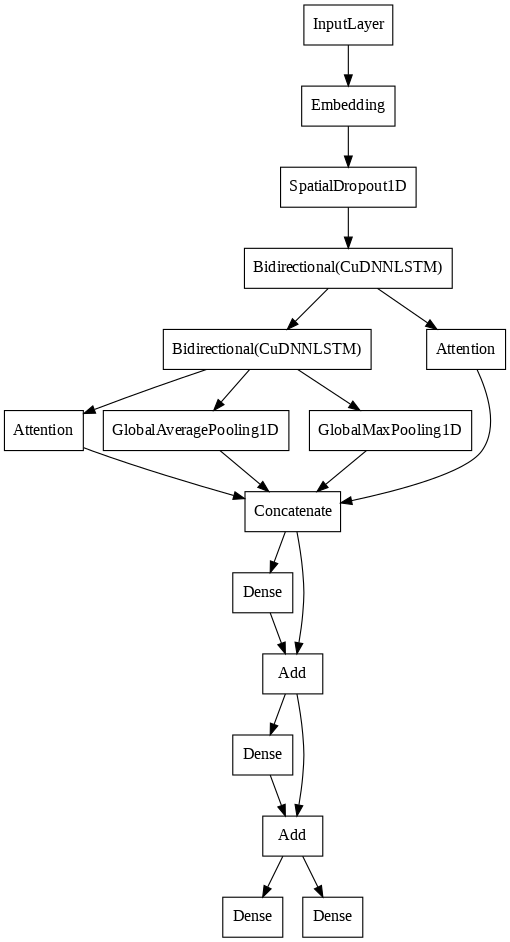

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=False, show_layer_names=False, dpi=80)

<h3> Training the model: </h3>

Generally, we obtain the final prediction after running the model for some epoch so that the weights are fully adjusted to the patterns in our data.

But here, we will produce predictions for each epoch and then combine them using some weights.

In [ ]:
checkpoint_predictions = []
weights_pred = []

In [ ]:
K.clear_session()
for model_idx in range(NUM_MODELS): 
    model = build_model(embedding_matrix, y_aux_train.shape[-1], loss_weight)
    for global_epoch in range(EPOCHS): 
        model.fit(
            x_train,
            [y_train, y_aux_train],
            batch_size=BATCH_SIZE,
            epochs=1,
            verbose=1,
            callbacks=[
                LearningRateScheduler(lambda epoch: 1e-3 * (0.6 ** global_epoch))
            ]
        )
        checkpoint_predictions.append(model.predict(x_test, batch_size=2048)[0].flatten())
        gc.collect()
        weights_pred.append(2 ** global_epoch)
    del model
    gc.collect()

Epoch 1/1
1804874/1804874 [==============================] - 1043s 578us/step - loss: 0.3953 - dense_3_loss: 0.0904 - dense_4_loss: 0.1052
Epoch 1/1
1804874/1804874 [==============================] - 1039s 575us/step - loss: 0.3821 - dense_3_loss: 0.0874 - dense_4_loss: 0.1015
Epoch 1/1
1804874/1804874 [==============================] - 1041s 577us/step - loss: 0.3780 - dense_3_loss: 0.0865 - dense_4_loss: 0.1005
Epoch 1/1
1804874/1804874 [==============================] - 1043s 578us/step - loss: 0.3754 - dense_3_loss: 0.0858 - dense_4_loss: 0.0999
Epoch 1/1
1804874/1804874 [==============================] - 1050s 582us/step - loss: 0.3953 - dense_7_loss: 0.0904 - dense_8_loss: 0.1053
Epoch 1/1
1804874/1804874 [==============================] - 1048s 580us/step - loss: 0.3822 - dense_7_loss: 0.0875 - dense_8_loss: 0.1015
Epoch 1/1
1804874/1804874 [==============================] - 1045s 579us/step - loss: 0.3780 - dense_7_loss: 0.0865 - dense_8_loss: 0.1005
Epoch 1/1
 653568/1804874 [

In [ ]:
# calculates the weighted average for the epoch predictions
predictions = np.average(checkpoint_predictions, weights=weights_pred, axis=0)

In [ ]:
test_df = pd.read_csv('/content/drive/My Drive/Jigsaw/test.csv.zip')
submission = pd.DataFrame.from_dict({
    'id': test_df['id'],
    'prediction': predictions
})

In [ ]:
submission.to_csv('submission_luongnew.csv', index=False)

# Summary:

__The brief overview of the network__:

- I used two layers of __bi-LSTM__ Layer

- I used two __Attention__ layers with __GlobalAveragePooling1D__ and __GlobalMaxPooling1D__

- Linear layers with with skip connections.

- __Optimizer__ - standard Adam with default LR

- __customloss__ function that weights identity's information.

- The result prediction is weighted average of every epoch output.

Things that did not work:

- I also tried to use features such as `toxicity_annotator_count `, `rating`, `funny`, `wow`, `sad`, `likes`, `disagree` in the model. But they did not add much value to the network I defined.

# Conclusion:


The __KAGGLE__ scores and the __LB__ ranking for the model is summarised below:

- __KAGGLE Score__: 0.93623
- __LB__: 629/2633

![Score Image https://i.imgur.com/bSNNkDg.jpg](https://i.imgur.com/YlSuQPC.jpg)

![LB Image https://i.imgur.com/OIMVkfA.jpg](https://i.imgur.com/MYSr7WG.jpg)

# References:

- https://www.analyticsvidhya.com/blog/2019/11/comprehensive-guide-attention-mechanism-deep-learning/

- https://towardsdatascience.com/attn-illustrated-attention-5ec4ad276ee3#ba24

- https://blog.floydhub.com/attention-mechanism/

- https://medium.com/@joealato/attention-in-nlp-734c6fa9d983

- https://www.kaggle.com/uysimty/simple-toxicity-classification

- https://www.kaggle.com/duykhanh99/bidirectional-lstm-attention

- https://brahma0545.github.io/ML/7-seq-seq-models/
